## Lightning data viewer

In [52]:
import pyart
import numpy as np
import pandas
from matplotlib import pyplot as plt
from matplotlib import dates
from datetime import datetime
import time
from netCDF4 import Dataset
%matplotlib inline
import parse
import glob
from copy import deepcopy
import math

In [53]:
lightning_data_path = '/home/rjackson/data/lightning/'
data_path_cpol_cfradial = '/home/rjackson/data/radar/cpol/'
scp_netcdf_file_path = '/home/rjackson/data/SCP.cdf'

start_time = datetime(2006,1,19,0,0,0)
end_time = datetime(2006,1,25,0,0,1)

In [54]:
# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_cpol_cfradial(time):
    from datetime import timedelta, datetime
    import glob
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    
    if(time.year <= 2007):
        file_name_str = (data_path_cpol_cfradial +
                        '/' +
                        year_str +
                        '/' +
                        year_str +
                        month_str +
                        day_str +
                        '/'
                        'Gunn_pt_' +
                        year_str +
                        month_str +
                        day_str +
                        hour_str +
                        minute_str +
                        '*.nc')
    else:
        file_name_str = (data_path_cpol_cfradial + 
                         '/' +
                         year_str + 
                         '/' +
                         year_str + 
                         month_str +
                         day_str +
                         '/' +  
                         'cfrad.' +
                         year_str +
                         month_str +
                         day_str +
                         '_' +
                         hour_str +
                         minute_str +
                         '*.nc')
    print('Opening ' + file_name_str)
    file_name = glob.glob(file_name_str)
    radar = pyart.io.read(file_name[0])
    return radar

# get_radar_times_cpol
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_cpol_cfradial(start_year, start_month, start_day,
                                  start_hour, start_minute, end_year,
                                  end_month, end_day, end_hour, 
                                  end_minute, minute_interval=1):

    from datetime import timedelta, datetime
    from parse import parse
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )  

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = range(0, no_days)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    date_list_final = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        if(cur_time.year > 2007):
            format_str = (data_path_cpol_cfradial + 
                          '/' +
                          year_str + 
                          '/' +
                          year_str +
                          month_str +
                          day_str +
                          '/'
                          'cfrad.' +
                          year_str +
                          month_str +
                          day_str +
                          '*UNKNOWN_SUR.nc')
        else:
            format_str = (data_path_cpol_cfradial + 
                          '/' +
                          year_str + 
                          '/' +
                          year_str +
                          month_str +
                          day_str +
                          '/'
                          'Gunn_pt*' +
                          year_str +
                          month_str +
                          day_str +
                          '*ppi.nc')
        
        print('Looking for files with format ' + format_str)      
        data_list = glob.glob(format_str)
        
        if(len(data_list) > 0):
            day = datetime(cur_time.year, cur_time.month, cur_time.day, 0, 0, 1)
            date_list_final.append(day)
 
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        if(not file_name[-6:] == 'ppi.nc'):
            new_format_str = (data_path_cpol_cfradial +
                              '/' +
                              '{:d}' +
                              '/' +
                              '{:d}' +
                              '/' +
                              'cfrad.{:d}_{:d}.{:d}_to_{:d}_{:d}.{:d}_Gunn_Pt_v{:d}_UNKNOWN_SUR.nc')
            print(file_name)
            parameters = parse(new_format_str, file_name)
            year_str = np.floor(parameters[2]/10000)
            month_str = np.floor((parameters[2]-year_str*10000)/100)
            day_str = np.floor(parameters[2]-year_str*10000-month_str*100)
            hour_str = np.floor(parameters[3]/10000)
            minute_str = np.floor((parameters[3]-hour_str*10000)/100)
            second_str = np.floor(parameters[3]-hour_str*10000-minute_str*100)    
        else:
            date_str = file_name[-20:-6]
            year_str = date_str[0:4]
            month_str = date_str[4:6]
            day_str = date_str[6:8]
            hour_str = date_str[8:10]
            minute_str = date_str[10:12]
            second_str = date_str[12:14]

        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
       
    for times in time_list_sorted:      
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                   
    return time_list_final, date_list_final


## Statistical coverage product for TWP ICE + lightning data

In [55]:
scp_netcdf = Dataset(scp_netcdf_file_path, mode='r')

years = scp_netcdf.variables['years'][:]
months = scp_netcdf.variables['months'][:]
days = scp_netcdf.variables['days'][:]
hours = scp_netcdf.variables['hours'][:]
minutes = scp_netcdf.variables['minutes'][:]
SCP0 = scp_netcdf.variables['SCP0'][:,:]
SCP10 = scp_netcdf.variables['SCP10'][:,:]
SCP20 = scp_netcdf.variables['SCP20'][:,:]
SCP30 = scp_netcdf.variables['SCP30'][:,:]
SCP40 = scp_netcdf.variables['SCP40'][:,:]
levels = scp_netcdf.variables['levels'][:]
maxz = scp_netcdf.variables['maxz'][:]
scp_netcdf.close()

In [57]:
date_strs = ['20060119', 
             '20060120', 
             '20060121',
             '20060122',
             '20060123',
             '20060124']
lats = []
lons = []
heights = []
amplitudes = []
datenums = []
for strs in date_strs:
    data = pandas.read_csv((lightning_data_path + 
                            'linet_dlr_' +
                            strs +
                            '_L1V1F2.lin'),
                           header=82,
                           delim_whitespace=True)

    data_matrix = np.ma.array(data.values)
    date = data_matrix[:,0]
    time_str = data_matrix[:,1]
    datetimes = []
    i = 0
    for days_l in date:
        year = np.floor(days_l/1e4)
        month = np.floor((days_l-year*1e4)/1e2)
        day = days_l-year*1e4-month*1e2
        time_obj = time.strptime(time_str[i], '%H:%M:%S.%f')
        date_obj = datetime(year=int(year), 
                            month=int(month), 
                            day=int(day),
                            hour=int(time_obj.tm_hour),
                            minute=int(time_obj.tm_min),
                            second=int(time_obj.tm_sec))
        datetimes.append(dates.date2num(date_obj))
        i = i + 1
        
    datetimes = np.array(datetimes)
    lat = data_matrix[:,2]
    lon = data_matrix[:,3]
    height = data_matrix[:,4]
    amplitude = data_matrix[:,6]

    # Only include lightning strikes in CPOL's domain
    in_domain = np.logical_and(np.logical_and(lat > -12.7, lat < -12.0),
                               np.logical_and(lon > 130.4, lon < 131.5))
    indicies = np.where(in_domain)
    lats.append(lat[indicies])
    lons.append(lon[indicies])
    heights.append(height[indicies])
    amplitudes.append(amplitude[indicies])
    datenums.append(datetimes[indicies])

lats = np.concatenate(lats)
lons = np.concatenate(lons)
heights = np.concatenate(heights)
amplitudes = np.concatenate(amplitudes)
datenums_lightning = np.concatenate(datenums)

/home/rjackson/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


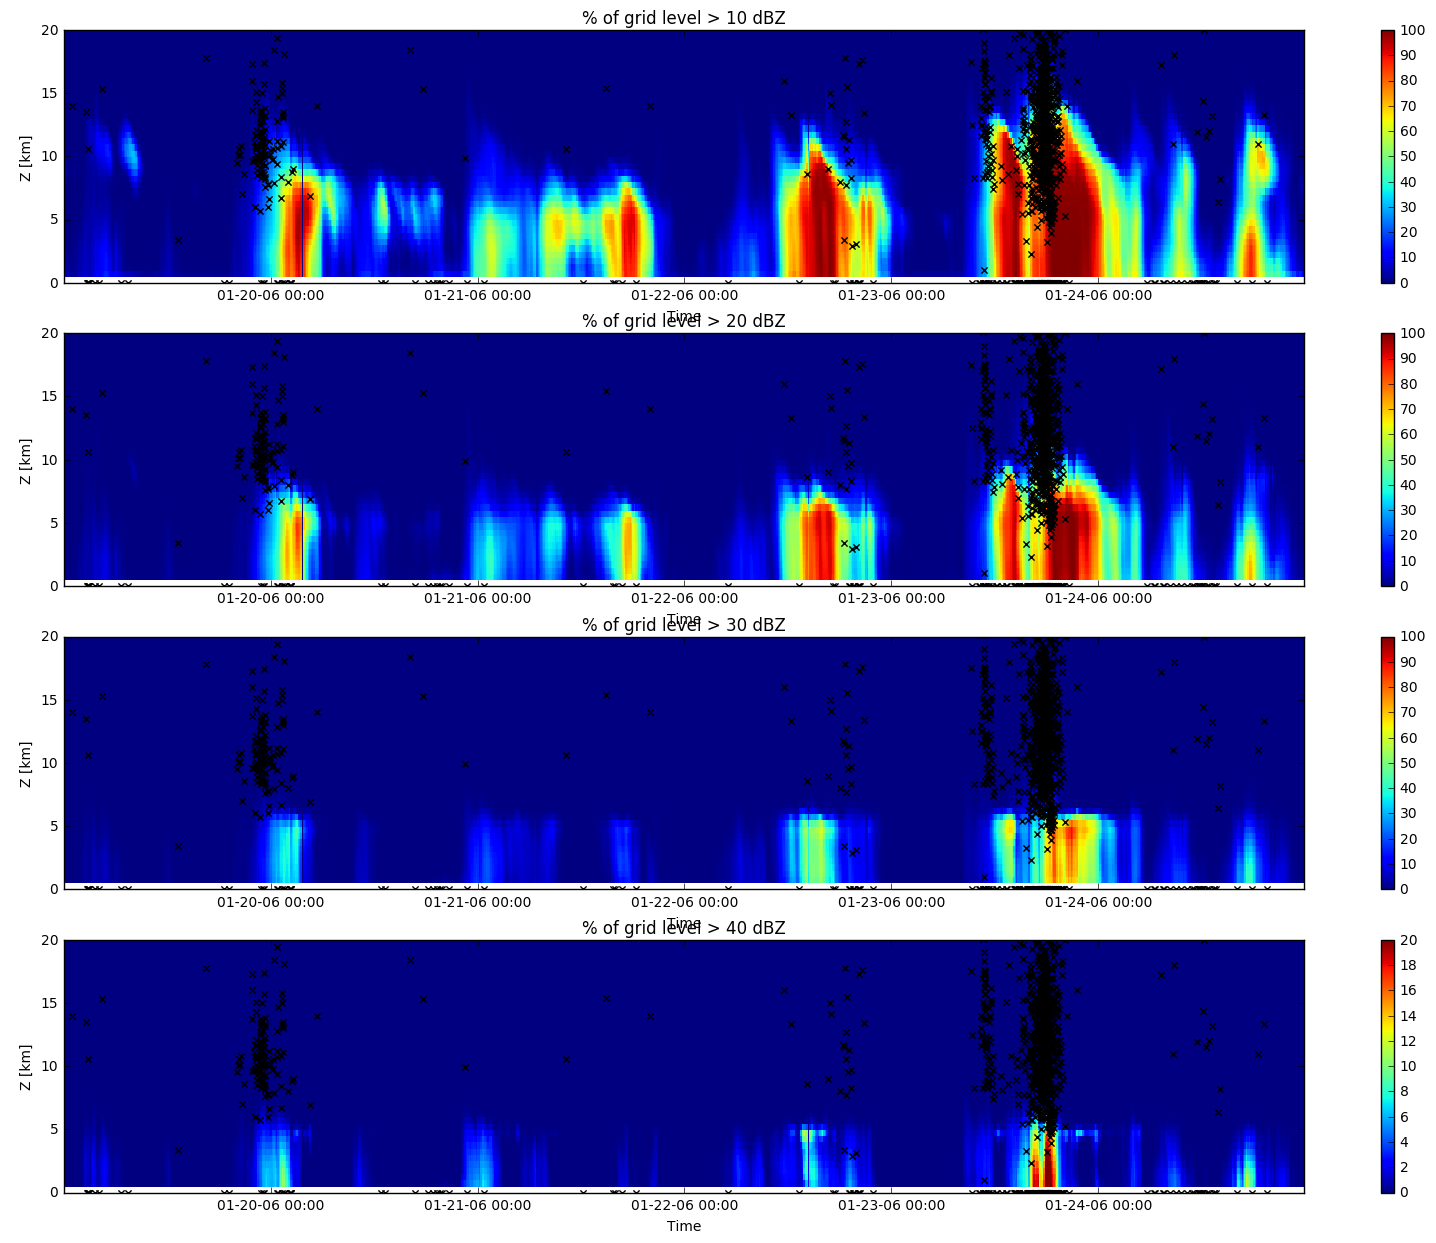

In [58]:
# Convert times to numerical format
datenums = []
indicies = []
for i in range(0,len(years)):
    temp_date = datetime(year=years[i],
                         month=months[i],
                         day=days[i],
                         hour=hours[i],
                         minute=minutes[i],
                         )
    datenums.append(dates.date2num(temp_date))   

datenums = np.array(datenums)
indicies = [True if b >= dates.date2num(start_time) 
                 and b <= dates.date2num(end_time) else False for b in datenums]

datenums = datenums[np.where(indicies)]
years_z = years[np.where(indicies)]
months_z = months[np.where(indicies)]
days_z = days[np.where(indicies)]
hours_z = hours[np.where(indicies)]
minutes_z = hours[np.where(indicies)]
SCP0z = np.squeeze(SCP0[np.where(indicies),:])
SCP10z = np.squeeze(SCP10[np.where(indicies),:])
SCP20z = np.squeeze(SCP20[np.where(indicies),:])
SCP30z = np.squeeze(SCP30[np.where(indicies),:])
SCP40z = np.squeeze(SCP40[np.where(indicies),:])

num_dates = len(datenums)

datelocs = []
for i in range(0, num_dates, int(num_dates/6)):
    temp_date = datetime(year=years_z[i],
                         month=months_z[i],
                         day=days_z[i],
                         hour=hours_z[i],
                         minute=minutes_z[i],
                         )
    datelocs.append(temp_date)
    
x = dates.date2num(datelocs)    


# Create meshgrid for contour plot
times, lvls = np.meshgrid(datenums,levels)

contour_levels = [1, 5, 10,20,30,40]
# Plot contour figure
plt.figure(figsize=(20,15))

plt.subplot(411)
CS = plt.pcolormesh(times,lvls,np.transpose(SCP10z))
ax = plt.colorbar()
plt.clim([0, 100])
plt.gca().set_xticks(x)
# Set the xtick labels to correspond to just the dates you entered.
plt.gca().set_xticklabels([date.strftime("%m-%d-%y %H:%M") for date in datelocs])
plt.scatter(datenums_lightning[::10], heights[::10], color='k', marker='x')
plt.xlim([times[0,0], times[-1,-1]])
plt.ylim([0,20])
plt.ylabel('Z [km]')
plt.xlabel('Time')
plt.title('% of grid level > 10 dBZ')

plt.subplot(412)
CS = plt.pcolormesh(times,lvls,np.transpose(SCP20z))
ax = plt.colorbar()
plt.clim([0, 100])
plt.gca().set_xticks(x)
# Set the xtick labels to correspond to just the dates you entered.
plt.gca().set_xticklabels([date.strftime("%m-%d-%y %H:%M") for date in datelocs])
plt.scatter(datenums_lightning[::10], heights[::10], color='k', marker='x')
plt.xlim([times[0,0], times[-1,-1]])
plt.ylim([0,20])
plt.ylabel('Z [km]')
plt.xlabel('Time')
plt.title('% of grid level > 20 dBZ')

plt.subplot(413)
CS = plt.pcolormesh(times,lvls,np.transpose(SCP30z))
ax = plt.colorbar()
plt.clim([0, 100])
plt.gca().set_xticks(x)
# Set the xtick labels to correspond to just the dates you entered.
plt.gca().set_xticklabels([date.strftime("%m-%d-%y %H:%M") for date in datelocs])
plt.scatter(datenums_lightning[::10], heights[::10], color='k', marker='x')
plt.xlim([times[0,0], times[-1,-1]])
plt.ylim([0,20])
plt.ylabel('Z [km]')
plt.xlabel('Time')
plt.title('% of grid level > 30 dBZ')

plt.subplot(414)
CS = plt.pcolormesh(times,lvls,np.transpose(SCP40z))
ax = plt.colorbar()
plt.clim([0, 20])
plt.gca().set_xticks(x)
# Set the xtick labels to correspond to just the dates you entered.
plt.gca().set_xticklabels([date.strftime("%m-%d-%y %H:%M") for date in datelocs])
plt.scatter(datenums_lightning[::10], heights[::10], color='k', marker='x')
plt.xlim([times[0,0], times[-1,-1]])
plt.ylim([0,20])
plt.ylabel('Z [km]')
plt.xlabel('Time')
plt.title('% of grid level > 40 dBZ')

## QVPs TWP-ICE

In [67]:
times = get_radar_times_cpol_cfradial(2006,1,19,0,1,
                                      2006,1,25,0,2)

We are about to load grid files for 8 days
Looking for files with format /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt*20060119*ppi.nc
Looking for files with format /home/rjackson/data/radar/cpol//2006/20060120/Gunn_pt*20060120*ppi.nc
Looking for files with format /home/rjackson/data/radar/cpol//2006/20060121/Gunn_pt*20060121*ppi.nc
Looking for files with format /home/rjackson/data/radar/cpol//2006/20060122/Gunn_pt*20060122*ppi.nc
Looking for files with format /home/rjackson/data/radar/cpol//2006/20060123/Gunn_pt*20060123*ppi.nc
Looking for files with format /home/rjackson/data/radar/cpol//2006/20060124/Gunn_pt*20060124*ppi.nc
Looking for files with format /home/rjackson/data/radar/cpol//2006/20060125/Gunn_pt*20060125*ppi.nc
Looking for files with format /home/rjackson/data/radar/cpol//2006/20060126/Gunn_pt*20060126*ppi.nc


In [ ]:
sweep = 12 # 17.5 degrees
refl = []
rhv = []
zdrs = []
zs = []
datenums_qvp = []
for rad_time in times[0]:
    radar = get_radar_from_cpol_cfradial(rad_time)
    ref = radar.get_field(sweep, 'reflectivity')
    zdr = radar.get_field(sweep, 'differential_reflectivity')
    rhohv = radar.get_field(sweep, 'cross_correlation_ratio')
    azimuth = radar.get_azimuth(sweep)
    x,y,z = radar.get_gate_x_y_z(sweep)
    sweep_shape = ref.shape
    print(sweep_shape)
    # Correct ZDR for orientation
    azimuth[azimuth > 180] = azimuth[azimuth > 180] - 360
    
    for j in range(0,sweep_shape[1]):
        azimuth_is_zero = np.where(np.abs(azimuth) < 1)
        zdr0 = np.mean(zdr[azimuth_is_zero[0],j])
        zdr[:,j] = zdr0/(np.square(np.sqrt(zdr0) *
                         np.square(np.sin(azimuth*math.pi/180)) +
                         np.square(np.cos(azimuth*math.pi/180))))
    zdr_mean = np.nanmean(zdr,1)
    z_mean = np.nanmean(z,1)
    ref_mean = np.nanmean(ref,1)
    rhohv_mean = np.nanmean(rhohv,1)
    zdrs.append(zdr_mean)
    refl.append(ref_mean)
    rhv.append(rhohv_mean)
    zs.append(z_mean)
    datenums_qvp.append(dates.date2num(rad_time))

Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190010*.nc
(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190020*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190030*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190040*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190050*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190100*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190110*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190120*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190130*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190140*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190150*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190200*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190210*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190220*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190230*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190240*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190250*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190300*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190310*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190320*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190330*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190340*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190350*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190400*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190410*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190420*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190430*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190440*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190450*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190500*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190510*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190520*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190530*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190540*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190550*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190600*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(241, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190610*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(241, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190620*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190630*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190640*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190650*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190700*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190710*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190720*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190730*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190740*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190750*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190800*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190810*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190820*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190830*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190840*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190850*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190900*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190910*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190920*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190930*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190940*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601190950*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191000*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191010*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191020*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191030*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191040*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191050*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191100*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191110*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191120*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191130*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191140*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191150*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191200*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191210*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191220*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191230*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191240*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191250*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191300*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191310*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191320*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191330*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191340*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191350*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191400*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191410*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191420*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191430*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191440*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191450*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191500*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191510*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191520*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191530*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191540*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191550*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191600*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191610*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191620*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191630*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191640*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191650*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191700*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191710*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191720*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191730*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191740*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191750*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191800*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191810*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191820*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191830*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191840*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191850*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191900*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191910*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191920*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191930*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191940*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601191950*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192000*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192010*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192020*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192030*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192040*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192050*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192100*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192110*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(242, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192120*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


(243, 480)
Opening /home/rjackson/data/radar/cpol//2006/20060119/Gunn_pt_200601192130*.nc


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
